In [1]:
# Import required libraries
import os
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

# For inline plotting in notebooks
%matplotlib inline


In [2]:
# Define paths for the ZIP file and extraction folder
zip_path = "BCImages.zip"  
extraction_path = "./BCImages"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Extracted contents to: {extraction_path}")
print("Extracted folders and files:", os.listdir(extraction_path))


Extracted contents to: ./BCImages
Extracted folders and files: ['BrandedCharacters_Images']


In [3]:
# Set the base folder 
base_folder = os.path.join(extraction_path, "BrandedCharacters_Images")
print(f"Contents of {base_folder}: {os.listdir(base_folder)}")

# Example: Inspect one character folder 
character_folder = os.path.join(base_folder, "ColonelSanders")
if os.path.exists(character_folder):
    print(f"Contents of {character_folder}: {os.listdir(character_folder)}")
    images = [img for img in os.listdir(character_folder) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Number of images in {character_folder}: {len(images)}")


Contents of ./BCImages/BrandedCharacters_Images: ['ColonelSanders', 'MM', 'CookieGuy', 'NesquickBunny', 'RonaldMcdonald', 'DoughBoy', 'ChesterCheetah', 'TonyTiger', 'MrPeanut', 'KoolAidMan']
Contents of ./BCImages/BrandedCharacters_Images/ColonelSanders: ['CS_1_img3.jpg', 'CS_19_img8.jpg', 'CS_6_img2.jpg', 'CS_10_img1.jpg', 'CS_17_img3.jpg', 'CS_19_img11.jpg', 'CS_1_img1.jpg', 'CS_14_img3.jpg', 'CS_19_img12.jpg', 'CS_11_img3.jpg', 'CS_7_img3.jpg', 'CS_2_img7.jpg', 'CS_7_img1.jpg', 'CS_18_img1.jpg', 'CS_3_img1.jpg', 'CS_8_img2.jpg', 'CS_20_img2.jpg', 'CS_19_img3.jpg', 'CS_19_img4.jpg', 'CS_2_img3.jpg', 'CS_19_img6.jpg', 'CS_10_img3.jpg', 'CS_19_img5.jpg', 'CS_2_img1.jpg', 'CS_12_img2.jpg', 'CS_11_img1.jpg', 'CS_2_img6.jpg', 'CS_16_img1.jpg', 'CS_6_img1.jpg', 'CS_10_img4.jpg', 'CS_1_img5.jpg', 'CS_4_img1.jpg', 'CS_17_img2.jpg', 'CS_10_img5.jpg', 'CS_2_img2.jpg', 'CS_11_img4.jpg', 'CS_11_img2.jpg', 'CS_14_img2.jpg', 'CS_12_img4.jpg', 'CS_19_img2.jpg', 'CS_14_img1.jpg', 'CS_8_img3.jpg', 'C

In [4]:
# Define paths and split ratios
output_base_folder = "./SplitDataset"
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create directories for train, val, and test splits
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_base_folder, split), exist_ok=True)

# Process each character folder and split the images
for character in os.listdir(base_folder):
    character_path = os.path.join(base_folder, character)
    if os.path.isdir(character_path):
        print(f"Processing character: {character}")
        images = [img for img in os.listdir(character_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Split images using scikit-learn
        train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)
        
        # Create subdirectories for this character in each split and copy the files
        for split, imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_dir = os.path.join(output_base_folder, split, character)
            os.makedirs(split_dir, exist_ok=True)
            for img in imgs:
                shutil.copy(os.path.join(character_path, img), os.path.join(split_dir, img))
        
        print(f"{character} --> Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")


Processing character: ColonelSanders
ColonelSanders --> Train: 48, Val: 11, Test: 11
Processing character: MM
MM --> Train: 82, Val: 18, Test: 18
Processing character: CookieGuy
CookieGuy --> Train: 86, Val: 19, Test: 19
Processing character: NesquickBunny
NesquickBunny --> Train: 88, Val: 19, Test: 20
Processing character: RonaldMcdonald
RonaldMcdonald --> Train: 116, Val: 25, Test: 26
Processing character: DoughBoy
DoughBoy --> Train: 113, Val: 24, Test: 25
Processing character: ChesterCheetah
ChesterCheetah --> Train: 71, Val: 15, Test: 16
Processing character: TonyTiger
TonyTiger --> Train: 136, Val: 29, Test: 30
Processing character: MrPeanut
MrPeanut --> Train: 126, Val: 27, Test: 28
Processing character: KoolAidMan
KoolAidMan --> Train: 83, Val: 18, Test: 18


In [12]:
# Define image transformations for train, validation, and test sets
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Data augmentation for training
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]),
    ]),
}

data_dir = "./SplitDataset"
datasets_dict = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform['val']),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform['test']),
}

# Create DataLoaders for each dataset
batch_size = 32
dataloaders = {
    split: DataLoader(datasets_dict[split], batch_size=batch_size, shuffle=(split=='train'))
    for split in ['train', 'val', 'test']
}

# Get the class names
class_names = datasets_dict['train'].classes
print("Classes:", class_names)

Classes: ['ChesterCheetah', 'ColonelSanders', 'CookieGuy', 'DoughBoy', 'KoolAidMan', 'MM', 'MrPeanut', 'NesquickBunny', 'RonaldMcdonald', 'TonyTiger']


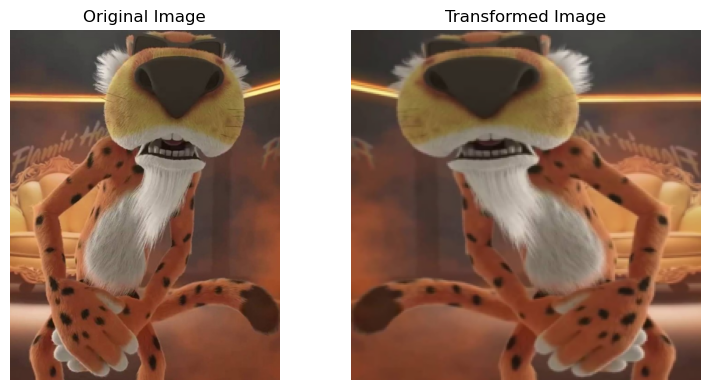

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load one image without any transformation (raw/original)
sample_path = datasets_dict['train'].imgs[0][0]  # path to first training image
original_image = Image.open(sample_path).convert("RGB")

# Apply only the train transform to get the 'after'
transformed_image = transform['train'](original_image)

# Function to unnormalize and convert tensor to numpy image
def imshow(tensor_img, title):
    image = tensor_img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean  # unnormalize
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

# Plotting
plt.figure(figsize=(8, 4))

# Original
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# Transformed
plt.subplot(1, 2, 2)
imshow(transformed_image, title="Transformed Image")

plt.tight_layout()
plt.show()


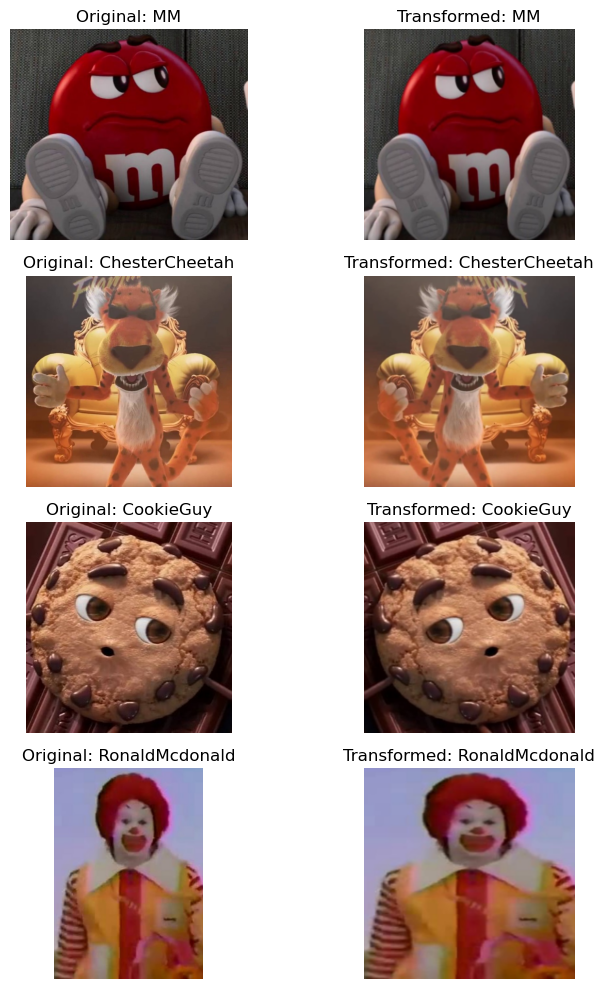

In [14]:
#before and after transformation of pictures
import random

dataset = datasets_dict['train']
num_samples = 4  
indices = random.sample(range(len(dataset)), num_samples)

fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2.5 * num_samples))

for i, idx in enumerate(indices):
    img_path = dataset.imgs[idx][0]
    label_idx = dataset.imgs[idx][1]
    class_name = class_names[label_idx]

    original = Image.open(img_path).convert("RGB")
    transformed = transform['train'](original)

    # Original image
    axes[i, 0].imshow(original)
    axes[i, 0].set_title(f"Original: {class_name}")
    axes[i, 0].axis('off')

    # Transformed image
    transformed_img = unnormalize(transformed)
    axes[i, 1].imshow(transformed_img)
    axes[i, 1].set_title(f"Transformed: {class_name}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [15]:
# Define the optimized CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Reduced dropout rate

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss function, optimizer, and scheduler
num_classes = len(class_names)
model = SimpleCNN(num_classes)

criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # With weight decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training parameters
num_epochs = 10
best_val_acc = 0.0
patience = 5       # Patience for early stopping
patience_counter = 0

# Lists to store training history (for plotting)
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

# Training and validation loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    train_loss = 0.0
    train_correct = 0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)
    
    train_loss /= len(datasets_dict['train'])
    train_acc = train_correct.double() / len(datasets_dict['train'])
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc.item())
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)
    
    val_loss /= len(datasets_dict['val'])
    val_acc = val_correct.double() / len(datasets_dict['val'])
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc.item())
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Early stopping: save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step()  # Update the learning rate


Epoch 1/10
Train Loss: 4.7398, Train Acc: 0.1855
Val Loss: 2.0321, Val Acc: 0.3902
Epoch 2/10
Train Loss: 1.8322, Train Acc: 0.3899
Val Loss: 1.4584, Val Acc: 0.5512
Epoch 3/10
Train Loss: 1.3377, Train Acc: 0.5543
Val Loss: 0.9269, Val Acc: 0.7268
Epoch 4/10
Train Loss: 1.0265, Train Acc: 0.6512
Val Loss: 0.7946, Val Acc: 0.7463
Epoch 5/10
Train Loss: 0.8076, Train Acc: 0.7144
Val Loss: 0.5545, Val Acc: 0.8341
Epoch 6/10
Train Loss: 0.6071, Train Acc: 0.8019
Val Loss: 0.4198, Val Acc: 0.8732
Epoch 7/10
Train Loss: 0.5014, Train Acc: 0.8325
Val Loss: 0.3714, Val Acc: 0.8927
Epoch 8/10
Train Loss: 0.4751, Train Acc: 0.8398
Val Loss: 0.3786, Val Acc: 0.8732
Epoch 9/10
Train Loss: 0.4623, Train Acc: 0.8577
Val Loss: 0.3608, Val Acc: 0.8927
Epoch 10/10
Train Loss: 0.3769, Train Acc: 0.8767
Val Loss: 0.3295, Val Acc: 0.8976


/tmp/ipykernel_2565/3320687950.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 0.8720


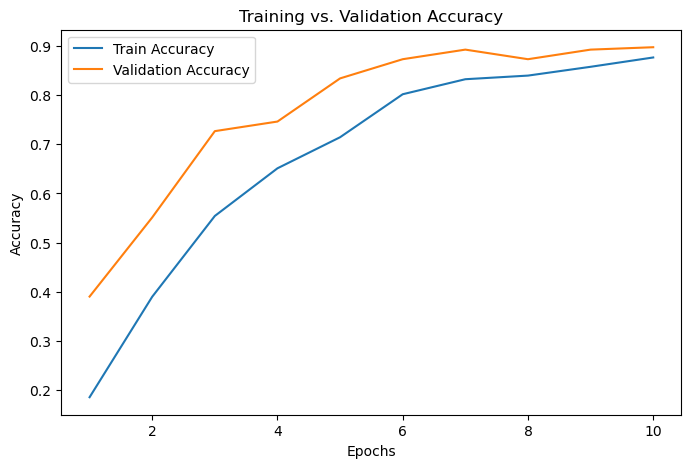

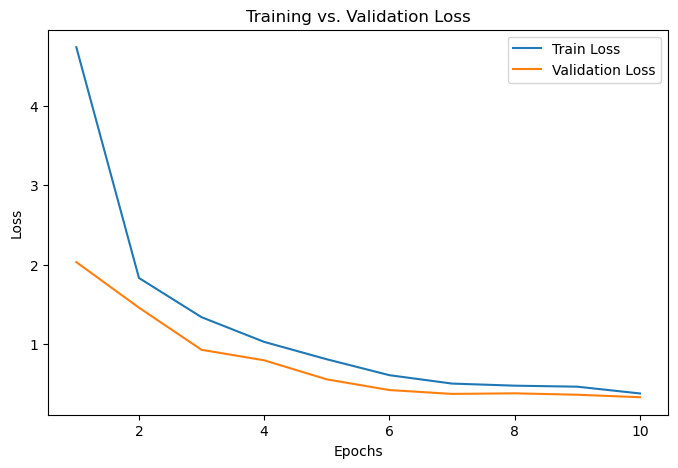

In [17]:
# Load the best saved model and evaluate on the test set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_correct = 0
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
        
test_acc = test_correct.double() / len(datasets_dict['test'])
print(f"Test Accuracy: {test_acc:.4f}")

# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Function to display an image tensor
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize a few predictions from the test set
model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for i in range(min(4, inputs.size(0))):
            imshow(inputs[i], title=f'Predicted: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}')
        break  # Only display one batch


In [ ]:
from sklearn.metrics import confusion_matrix
# !pip install seaborn
import seaborn as sns

# Collect all predictions and true labels from the test set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate and print the classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n")
print(report)


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import torch

# Collect predicted probabilities and true labels from the test set
all_probs = []   # To store probabilities for each class, shape: [n_samples, num_classes]
all_labels = []  # To store true labels

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)  # Shape: [batch_size, num_classes]
        all_probs.append(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Concatenate the probabilities from all batches
all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.array(all_labels)

# Binarize the labels for multiclass ROC computation
num_classes = len(class_names)
y_test_bin = label_binarize(all_labels, classes=list(range(num_classes)))

# Compute ROC curves and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and the micro-average ROC curve
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='navy', linestyle='--', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random performance)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.show()


In [ ]:
all_confidences = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        confidences, _ = torch.max(torch.softmax(outputs, dim=1), 1)
        all_confidences.extend(confidences.cpu().numpy())

plt.figure(figsize=(8, 6))
plt.hist(all_confidences, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Confidences')
plt.show()


In [ ]:
misclassified_images = []
misclassified_true = []
misclassified_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified_images.append(inputs[i].cpu())
                misclassified_true.append(class_names[labels[i]])
                misclassified_pred.append(class_names[preds[i]])

# Display a few misclassified examples
num_display = 10
for i in range(min(num_display, len(misclassified_images))):
    imshow(misclassified_images[i], 
           title=f'Predicted: {misclassified_pred[i]}, True: {misclassified_true[i]}')
